<img src="https://pbs.twimg.com/profile_images/1092394418135539713/eplLRcDN_400x400.jpg" width=80px style="text-align:right"><h1>The Internet of Production Alliance </h1>

## Preliminary data report for the [OKW Map of Machines]()


Autor: Antonio de Jesus Anaya Hernandez, DevOps eng. for the IoPA.

Autor: The internet of Production Alliance, 2023.

Data was collected by "Fab Foundation", location: https://fablabs.io/

The Open Know Where (OKW) Standard is part of the Internet of Production Alliance and its members.

License: CC BY SA

![CC BY SA](https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by-sa.svg)

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [2]:
import concurrent.futures
import itertools

!pip install tabulate

In [3]:
from IPython.display import display, HTML

In [4]:
def binary_search(url):
    left = 0
    right = 50
    while left <= right:
        mid = (left + right) // 2
        r = requests.get(url + str(mid))
        if r.status_code == 200:
            page_content = BeautifulSoup(r.content, 'html.parser')
            machine_data = page_content.select('div.machines > div.machine')
            if len(machine_data) > 0:
                left = mid + 1
            else:
                right = mid - 1
        else:
            right = mid - 1
    return right

In [5]:
machines_url = 'https://fablabs.io/machines/?page='

In [6]:
def get_machines_list(page):
    global machines_url
    r = requests.get(machines_url + str(page))
    if r.status_code == 200:
        page_content = BeautifulSoup(r.content, 'html.parser')
        machine_data = page_content.select('div.machines > div.machine > div.card div > a', limit=0)
        machines = list(set([content['href'][10:] for content in machine_data if content['href'][:9] == '/machines']))
        return machines

In [7]:
with concurrent.futures.ThreadPoolExecutor(max_workers=20) as page_reader:
    pages_number = binary_search(machines_url)
    pages_read = [page_reader.submit(get_machines_list, int(page)) for page in range(1, pages_number+1)]
    machines_list = list(itertools.chain.from_iterable([future.result() for future in concurrent.futures.as_completed(pages_read)]))

In [8]:
# print(machines_list)

In [9]:
print(len(machines_list))

540


In [10]:
def get_machine_data(url):
    r = requests.get('https://fablabs.io/machines/' + url)
    
    if r.status_code == 200:
        page_content = BeautifulSoup(r.content, 'html.parser')
        labs_data = page_content.select('div.side > ul.list-unstyled > li > a', limit=0)
        labs = [content['href'][6:] for content in labs_data if content['href'][:5] == '/labs']
        machine_data = page_content.select('div.row > div.col-lg-8')
        machine_info = [x.text.replace("\n", "") for x in machine_data[0].children if x != '\n' and len(x.text) >= 1]
        tag_data = page_content.select('div.side > ul.taglist > li > strong > a', limit=0)
        tag_info = [content['href'][14:].replace("+", "_").replace("_%26_","_") for content in tag_data if content['href'][:9] == '/machines']
        # print(url)
        # print(machine_info)
        
        if len(labs) > 0:        
            return {'name':machine_info[1],'brand':machine_info[0],'labs':labs,'tags':tag_info}
        else:
            return url
    else:
        return (url, r.status_code)

In [11]:
with concurrent.futures.ThreadPoolExecutor(max_workers=20) as read_machines:
    future_results = [read_machines.submit(get_machine_data, url) for url in machines_list]
    
    results = [future.result() for future in concurrent.futures.as_completed(future_results)]

In [12]:
len(results)

540

In [13]:
# results

In [14]:
machines = pd.DataFrame([x for x in results if type(x) is dict])

In [15]:
machines.name = machines.name.str.lower()

In [16]:
machines.shape

(438, 4)

In [17]:
machines['machine_count'] = machines['labs'].str.len()

In [18]:
machines.set_index('name')

,brand,labs,tags,machine_count
name,,,,
kc4x380-s,Sieg,[fablabchateauthierry],[],1
protomat® s62,LPKF,"[aachen, fablabinatel, hrwfablab, fablabbkk]",[precision_milling],4
shopbot desktop,"ShopBot Tools, Inc","[fablabatyrau, lbsfablab, popplacevalenciennes...",[],17
makerbot z18,MakerBot Industries,"[musefablab, fablabzurich, minifablabutrecht, ...",[],30
bcn3d ignis,BCN3D Technologies,"[fablabterrassa, fablabmalaga]",[Laser_cut],2
...,...,...,...,...
compact 1208,Jaraguá CNC,[curitibafablab],[CNCMilling_RouterCNC],1
beambox,FLUX,[enterprisefablab],"[co2_laser, laser_engraver]",1
form cure,Formlabs,[enterprisefablab],"[sla, 3dprinting]",1


In [19]:
machines.machine_count.sum()

2326

In [20]:
machines.machine_count.max()

69

<AxesSubplot:ylabel='name'>

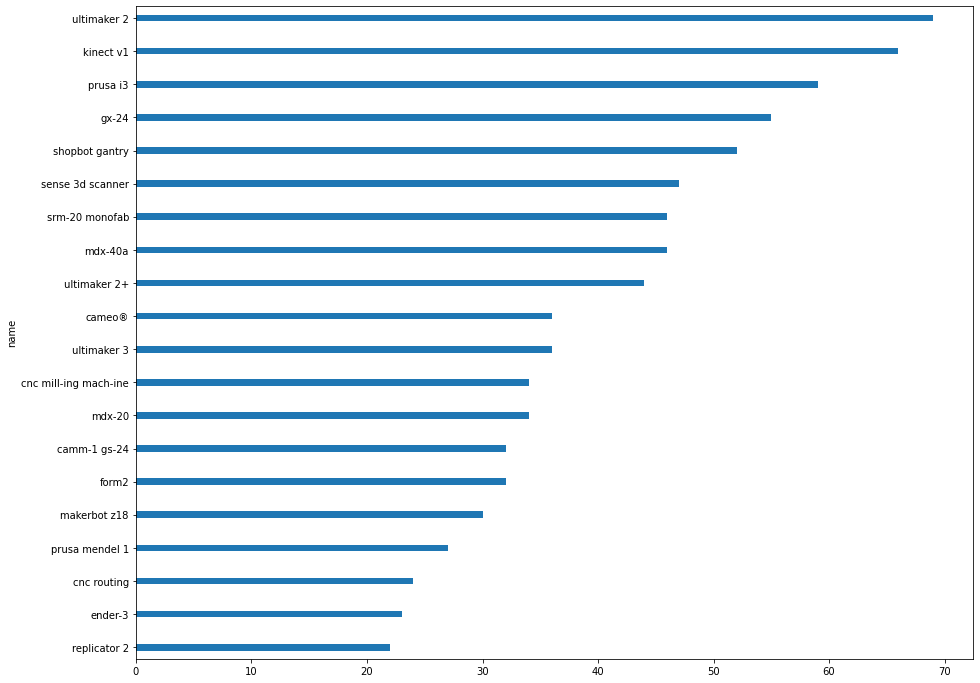

In [21]:
machines.set_index('name').machine_count.sort_values(ascending=True).tail(20).plot(kind='barh', rot=0, width=0.2, align='center', figsize=(15,12))

In [22]:
machines['tags'] = machines['tags'].apply(lambda x: [tag.replace('%23', '').replace('%3B', '').replace('%C2%AD', '').replace('%C3%A9', 'e').lower() for tag in x])

In [23]:
setof_tags = {tag for row in machines['tags'] for tag in row}

In [24]:
machines.tags

0                                                     []
1                                    [precision_milling]
2                                                     []
3                                                     []
4                                            [laser_cut]
                             ...                        
433                               [cncmilling_routercnc]
434                          [co2_laser, laser_engraver]
435                                    [sla, 3dprinting]
436                                    [sla, 3dprinting]
437    [specially_designed_to_minimize_the_sample_con...
Name: tags, Length: 438, dtype: object

In [28]:
machines['tagged'] = machines.tags.apply(lambda x: len(x) > 0)

In [48]:
classes_1 = {'three_d_printer': [x for x in setof_tags if '3d' in x and not 'sca' in x],
         'cnc_milling': [x for x in setof_tags if 'cnc' in x and not 'prec' in x and not 'laser' in x],
         'laser': [x for x in setof_tags if 'laser' in x],
         'circuit_production': [x for x in setof_tags if 'pcb' in x],
         'precision_milling': [x for x in setof_tags if 'prec' in x],
         'vinyl_cutting':[x for x in setof_tags if 'vinyl' in x],
         # 'other': [x for x in setof_tags if len(x) == 0],
        } 

In [49]:
classified_tags = set(val for sublist in classes_1.values() for val in sublist)

In [50]:
machines['classified'] = machines['tags'].apply(lambda x: True if any(tag in classified_tags for tag in x) else False)


In [51]:
machines.tagged == machines.classified

0       True
1       True
2       True
3       True
4       True
       ...  
433     True
434     True
435     True
436     True
437    False
Length: 438, dtype: bool

In [52]:
machines.classified

0      False
1       True
2      False
3      False
4       True
       ...  
433     True
434     True
435     True
436     True
437    False
Name: classified, Length: 438, dtype: bool

In [53]:
list(classes_1.keys())

['three_d_printer',
 'cnc_milling',
 'laser',
 'circuit_production',
 'precision_milling',
 'vinyl_cutting']

In [54]:
list(classes_1.values())

[['3dprinter_gtmax',
  'sethi3d_s3',
  '3d_printer',
  'resin_lcd_gtmax_gtmax3d_3dprint_3dprinter_brasil_brazil_fablab',
  'a_3d_printer3dprinter',
  '3d',
  '3dprinter_a_3d_printer',
  '3dp',
  'lynx_3d',
  'gtmax_gtmax3d_brasil_brazil',
  'delta_3d_printer',
  'dlp_3d_printer',
  '3d_printing',
  '3dpriner',
  'fdm_3d_print',
  '3d_machine',
  '3d_print_carbon_fiber',
  'fdm_desktop_3d_printer',
  'sls_3dprinting',
  '3dprinting',
  '3dprinter',
  '3d_printer_reprap_prusa_i3'],
 ['desktop_cnc',
  'cnc_router',
  'fresadora_router_cnc',
  'cnc_milling_machine',
  'cncmilling_routercnc',
  'cnc',
  'cnc-milling',
  'wood_lathe_cnc_machine',
  'milling_cnc',
  'cnc_milling',
  'cnc_carving',
  'cnc_lathe',
  'usinagem._fresadora_cnc_rizon_primalinea_router_cnc_router',
  'cnc_wood_lathe',
  'cnc_foam',
  'cnc_router_machine'],
 ['laser_engraving_machine',
  'lasercut',
  'laser_engraver_cutter_metal',
  'lasercnc',
  'laser_cutting_engraving',
  'laser',
  'laser_engraving_cutting',
  '

In [55]:
machines['class_1'] = machines['tags'].apply(lambda x: list(set([class_1 for tag in x for class_1 in list(classes_1.keys()) if tag in classes_1[class_1]])) if len(x) > 0 else [None]).apply(lambda x: [None] if len(x) == 0 else x)


In [56]:
print(*machines.class_1)


[None] ['precision_milling'] [None] [None] ['laser'] [None] ['three_d_printer'] [None] ['laser'] ['three_d_printer'] ['cnc_milling'] [None] [None] ['vinyl_cutting'] ['precision_milling'] ['laser'] [None] [None] ['three_d_printer'] [None] [None] ['cnc_milling'] [None] [None] [None] ['three_d_printer'] [None] [None] [None] ['laser'] [None] [None] [None] [None] ['laser'] [None] ['precision_milling'] ['three_d_printer'] [None] ['three_d_printer'] [None] ['three_d_printer'] [None] ['three_d_printer'] [None] [None] [None] ['laser'] ['three_d_printer'] [None] [None] ['precision_milling'] [None] [None] [None] ['laser'] [None] [None] [None] [None] [None] [None] ['cnc_milling'] ['cnc_milling', 'circuit_production', 'precision_milling'] ['three_d_printer'] ['three_d_printer'] ['cnc_milling', 'three_d_printer', 'laser'] [None] ['laser'] [None] ['cnc_milling'] [None] [None] ['three_d_printer'] ['three_d_printer'] ['three_d_printer'] [None] [None] [None] [None] ['cnc_milling'] [None] ['laser'] [None

In [58]:
for tags in machines.class_1:
    if len(tags) > 1:
        print(tags)

['cnc_milling', 'circuit_production', 'precision_milling']
['cnc_milling', 'three_d_printer', 'laser']
['laser', 'cnc_milling', 'three_d_printer']
['cnc_milling', 'three_d_printer']
['laser', 'cnc_milling', 'three_d_printer']


In [59]:
machines

,name,brand,labs,tags,machine_count,tagged,classified,class_1
0,kc4x380-s,Sieg,[fablabchateauthierry],[],1,False,False,[None]
1,protomat® s62,LPKF,"[aachen, fablabinatel, hrwfablab, fablabbkk]",[precision_milling],4,True,True,[precision_milling]
2,shopbot desktop,"ShopBot Tools, Inc","[fablabatyrau, lbsfablab, popplacevalenciennes...",[],17,False,False,[None]
3,makerbot z18,MakerBot Industries,"[musefablab, fablabzurich, minifablabutrecht, ...",[],30,False,False,[None]
4,bcn3d ignis,BCN3D Technologies,"[fablabterrassa, fablabmalaga]",[laser_cut],2,True,True,[laser]
...,...,...,...,...,...,...,...,...
433,compact 1208,Jaraguá CNC,[curitibafablab],[cncmilling_routercnc],1,True,True,[cnc_milling]
434,beambox,FLUX,[enterprisefablab],"[co2_laser, laser_engraver]",1,True,True,[laser]
435,form cure,Formlabs,[enterprisefablab],"[sla, 3dprinting]",1,True,True,[three_d_printer]
436,form wash l,Formlabs,[enterprisefablab],"[sla, 3dprinting]",1,True,True,[three_d_printer]


<AxesSubplot:ylabel='name'>

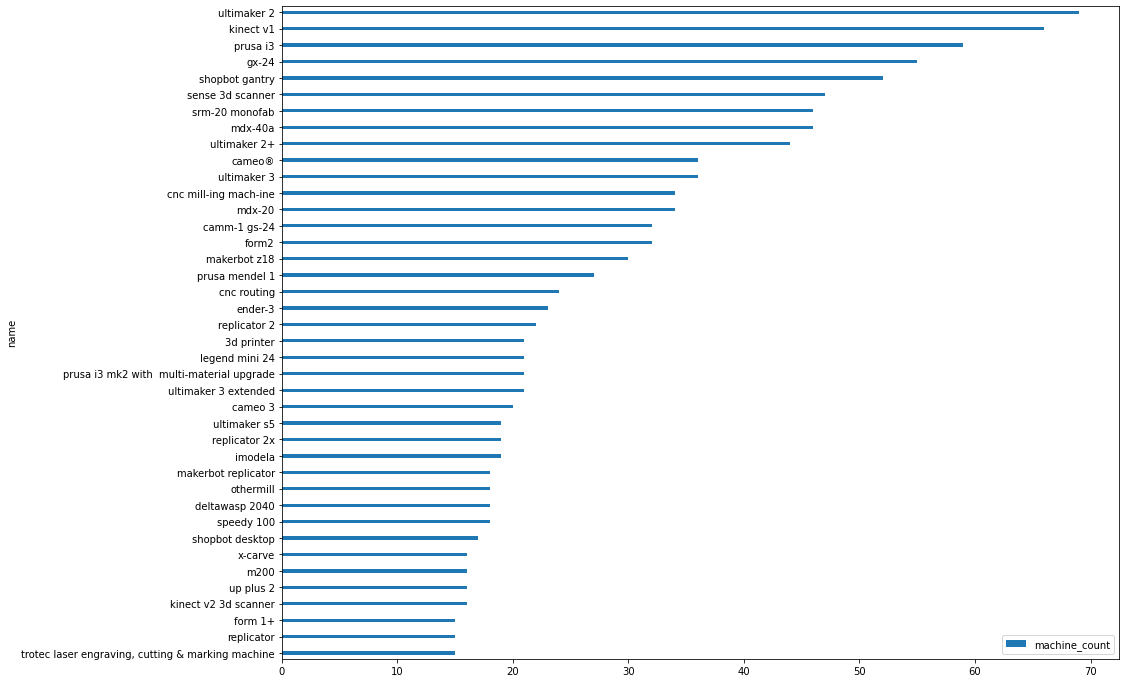

In [60]:
machines.set_index('name').sort_values('machine_count', ascending=True).tail(40).plot(kind='barh', rot=0, width=0.2, align='center', figsize=(15,12))

In [61]:
machines['class_1'] = machines['class_1'].apply(lambda x: max(set(x), key=x.count) if len(x)>0 else 'other')

class_1
three_d_printer      AxesSubplot(0.125,0.125;0.775x0.755)
laser                AxesSubplot(0.125,0.125;0.775x0.755)
vinyl_cutting        AxesSubplot(0.125,0.125;0.775x0.755)
precision_milling    AxesSubplot(0.125,0.125;0.775x0.755)
cnc_milling          AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

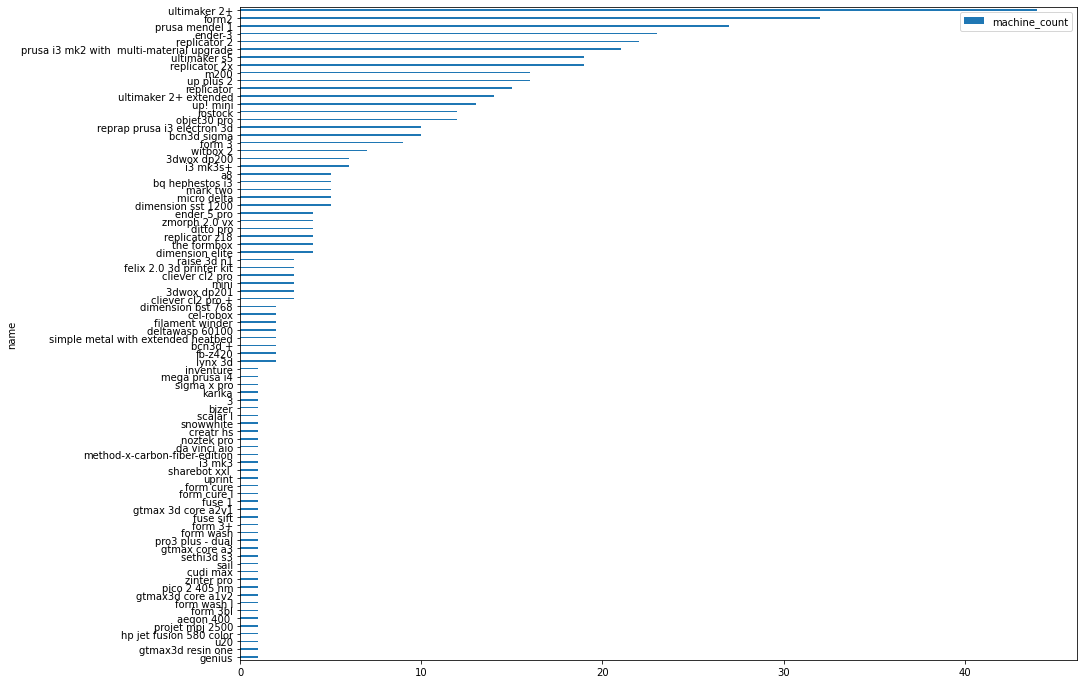

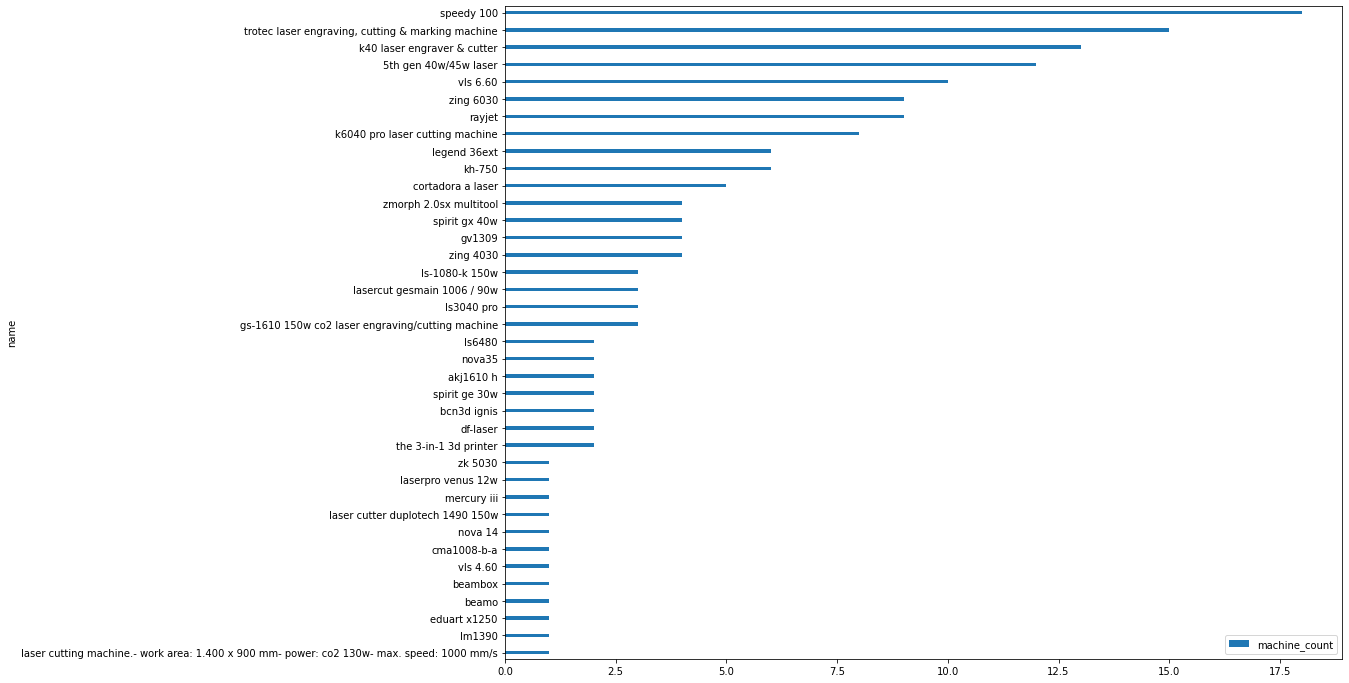

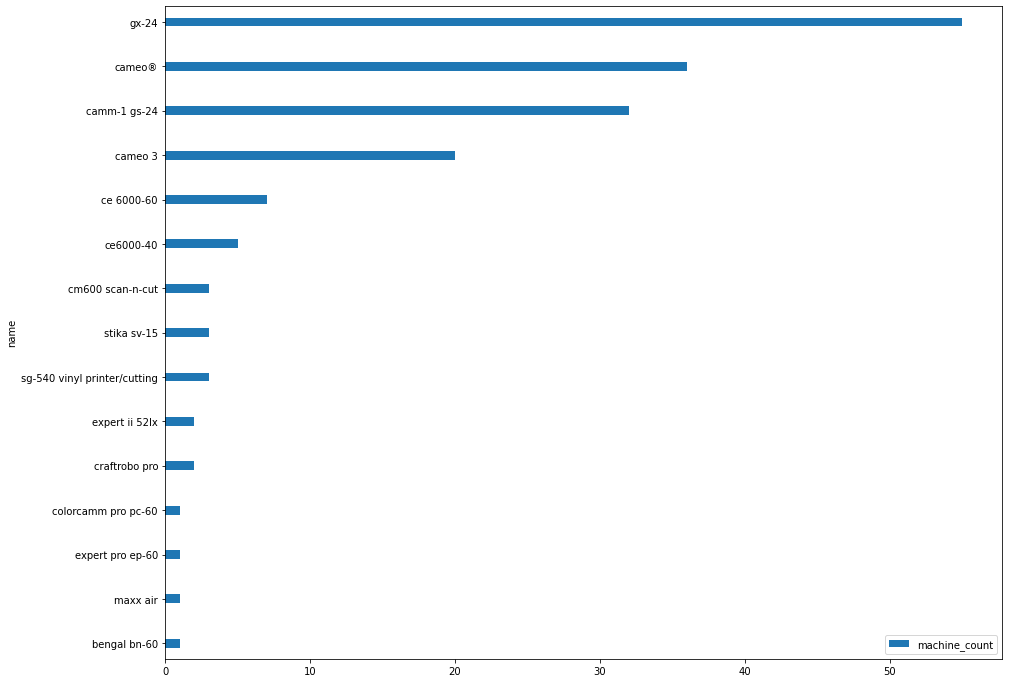

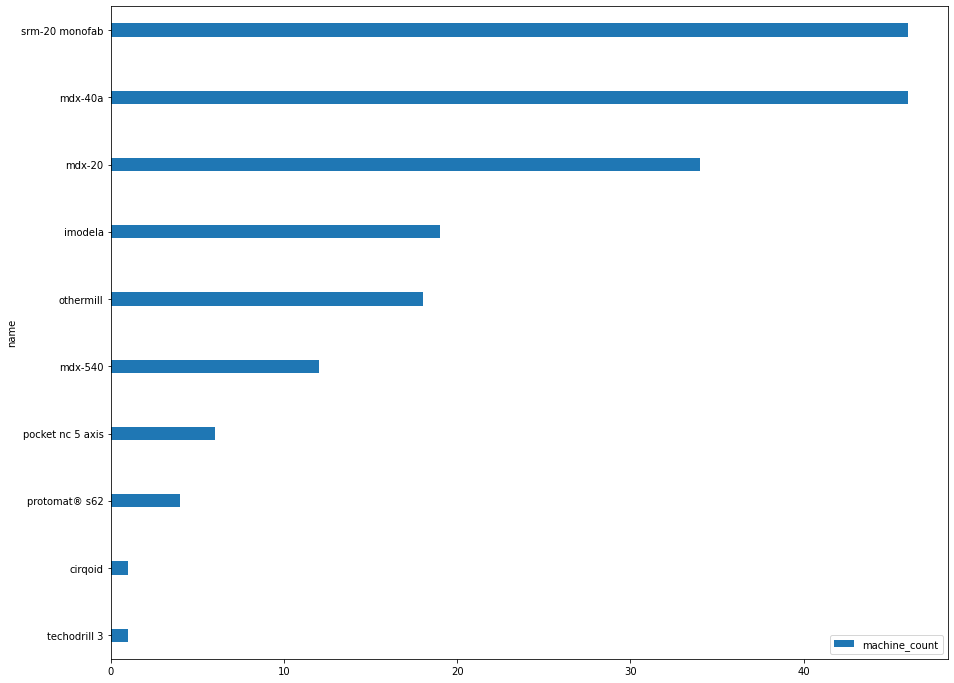

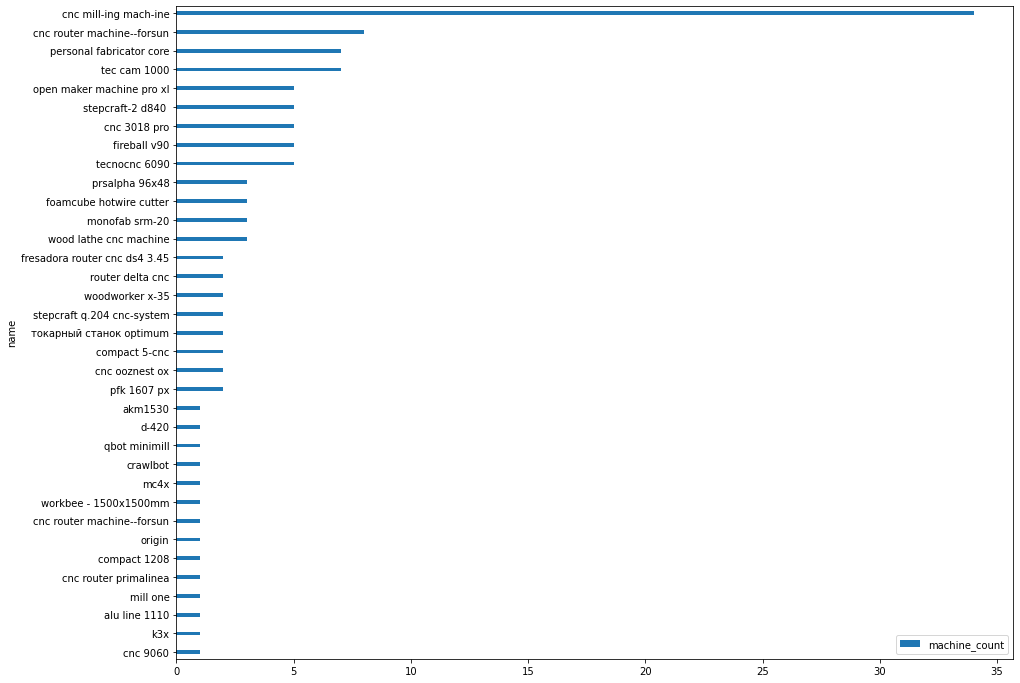

In [62]:
machines.sort_values('machine_count').set_index('name').groupby('class_1', sort=False).plot(kind='barh', rot=0, width=0.2, align='center', figsize=(15,12))

<AxesSubplot:ylabel='class_1'>

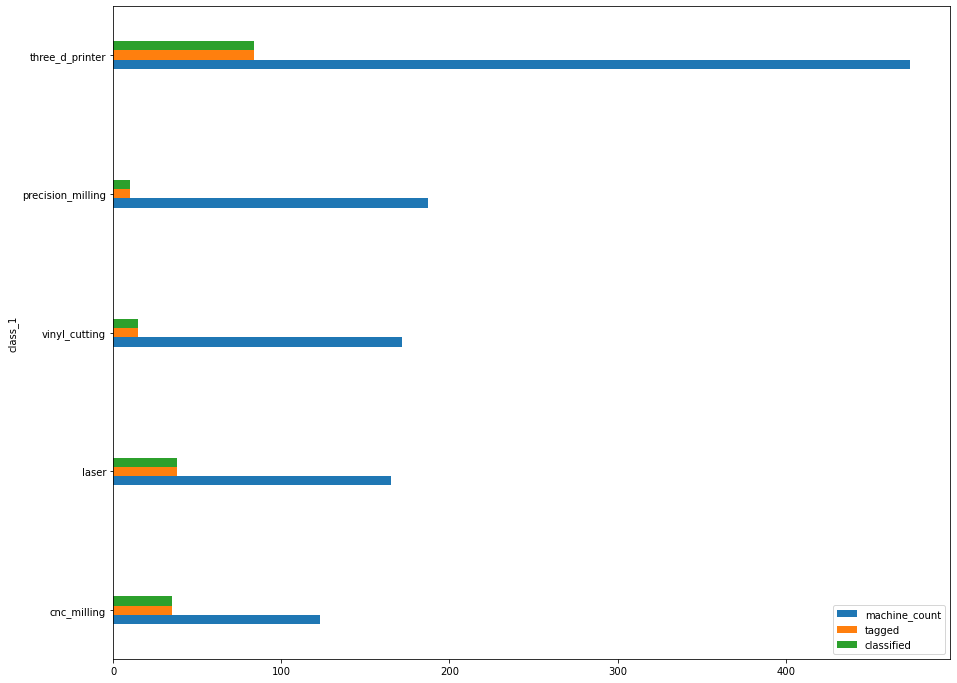

In [63]:
machines.groupby('class_1').sum().sort_values('machine_count').plot(kind='barh', rot=0, width=0.2, align='center', figsize=(15,12))

<AxesSubplot:>

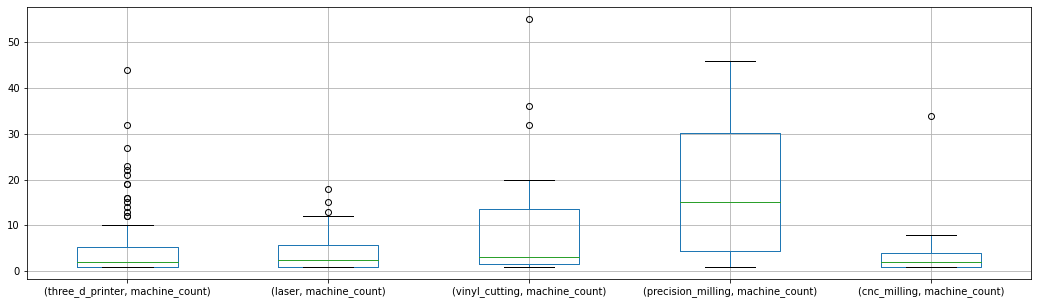

In [64]:
machines.sort_values('machine_count').groupby('class_1', sort=False).boxplot(column='machine_count', figsize=(18,5), subplots=False)

In [65]:
machines.sort_values('machine_count').groupby('class_1', sort=False)

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [67]:
df_copy = machines.copy()
df_copy.replace([None], np.nan, inplace=True)

In [68]:
df_copy.replace(False, np.nan, inplace=True)

In [69]:
df_copy = df_copy.apply(lambda x: np.nan if len(x) == 0 else x)

In [75]:
df_copy.isnull().sum()

name               0
brand              0
labs               0
tags               0
machine_count      0
tagged           155
classified       256
class_1          256
dtype: int64

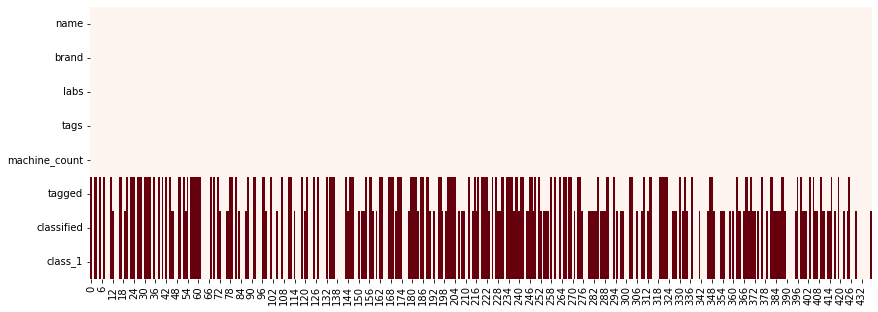

In [76]:
plt.figure(figsize = (14,5))
ax = sns.heatmap(df_copy.isnull().transpose(), cmap='Reds', cbar=False)

In [77]:
to_fill = [machine for index, machine in machines.iterrows() if machine[-1] == [None]]

In [79]:
machines.to_excel('machines.xlsx')

In [80]:
machines.to_csv('machines.csv')